# Определение эмоциональной окраски твитов с помощью BERT

In [1]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

!git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
import sys; sys.path.append('./stepik-dl-nlp')

!pip install pytorch-transformers

fatal: destination path 'stepik-dl-nlp' already exists and is not an empty directory.
     |████████████████████████████████| 184kB 8.2MB/s 
     |████████████████████████████████| 890kB 14.3MB/s 
     |████████████████████████████████| 133kB 23.8MB/s 
     |████████████████████████████████| 1.1MB 14.1MB/s 
     |████████████████████████████████| 71kB 9.8MB/s 
     |████████████████████████████████| 7.1MB 36.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=f3796dad4b9a276c2311281a735ba7a87eda44187572980c017cc5c05db29748
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
ERROR: botocore 1.19.40 has requirement urllib3<1.27,>=1.25.4; python_version != "3.4", but you'll have urllib3 1.24.3 which is incompatible.


## Импорт библиотек

In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig
from pytorch_transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == 'cpu':
    print('cpu')
else:
    n_gpu = torch.cuda.device_count()
    print(torch.cuda.get_device_name(0))

Tesla T4


## Загрузка данных


Мы выбрали необычный датасет с разметкой сентимента русскоязычных твитов (подробнее про него в [статье](http://www.swsys.ru/index.php?page=article&id=3962&lang=)). В корпусе, который мы использовали 114,911 положительных и 111,923 отрицательных записей. Загрузить его можно [тут](https://study.mokoron.com/).

In [ ]:
import pandas as pd

pos_texts = pd.read_csv('./stepik-dl-nlp/datasets/bert_sentiment_analysis/positive.csv', encoding='utf8', sep=';', header=None)
neg_texts = pd.read_csv('./stepik-dl-nlp/datasets/bert_sentiment_analysis/negative.csv', encoding='utf8', sep=';', header=None)

pos_texts.sample(5)

In [ ]:
sentences = np.concatenate([pos_texts[3].values, neg_texts[3].values])

sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = [[1] for _ in range(pos_texts.shape[0])] + [[0] for _ in range(neg_texts.shape[0])]

assert len(sentences) == len(labels) == pos_texts.shape[0] + neg_texts.shape[0]
print(sentences[1000])

In [ ]:
train_sentences, test_sentences, train_gt, test_gt = train_test_split(sentences, labels, test_size=0.3)
print(len(train_gt), len(test_gt))

## Inputs

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]
print(tokenized_texts[0])

BERTу нужно предоставить специальный формат входных данных.


- **input ids**: последовательность чисел, отождествляющих каждый токен с его номером в словаре.
- **labels**: вектор из нулей и единиц. В нашем случае нули обозначают негативную эмоциональную окраску, единицы - положительную.
- **segment mask**: (необязательно) последовательность нулей и единиц, которая показывает, состоит ли входной текст из одного или двух предложений. Для случая одного предложения получится вектор из одних нулей. Для двух: <length_of_sent_1> нулей и <length_of_sent_2> единиц.
- **attention mask**: (необязательно) последовательность нулей и единиц, где единицы обозначают токены предложения, нули - паддинг.

In [ ]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids,
    maxlen=100,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, train_gt, 
    random_state=42,
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.1
)

train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [ ]:
train_labels

In [ ]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=32
)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=32
)

## Обучение модели

Загружаем [BertForSequenceClassification](https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/pytorch_pretrained_bert/modeling.py#L1129):

In [ ]:
from pytorch_transformers import AdamW, BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

In [ ]:
from IPython.display import clear_output

# Будем сохранять loss во время обучения
# и рисовать график в режиме реального времени
train_loss_set = []
train_loss = 0


# Обучение
# Переводим модель в training mode
model.train()


for step, batch in enumerate(train_dataloader):
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # если не сделать .zero_grad(), градиенты будут накапливаться
    optimizer.zero_grad()
    
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

    train_loss_set.append(loss[0].item())  
    
    # Backward pass
    loss[0].backward()
    
    # Обновляем параметры и делаем шаг используя посчитанные градиенты
    optimizer.step()

    # Обновляем loss
    train_loss += loss[0].item()
    
    # Рисуем график
    clear_output(True)
    plt.plot(train_loss_set)
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.show()
    
print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))


# Валидация
# Переводим модель в evaluation mode
model.eval()

valid_preds, valid_labels = [], []

for batch in validation_dataloader:   
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для валидационных данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)     
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

# Оценка качества на отложенной выборке

In [ ]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sentences]
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

input_ids = pad_sequences(
    input_ids,
    maxlen=100,
    dtype="long",
    truncating="post",
    padding="post"
)

attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(test_gt)

prediction_data = TensorDataset(
    prediction_inputs,
    prediction_masks,
    prediction_labels
)

prediction_dataloader = DataLoader(
    prediction_data, 
    sampler=SequentialSampler(prediction_data),
    batch_size=32
)

In [ ]:
model.eval()
test_preds, test_labels = [], []

for batch in prediction_dataloader:
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для тестовых данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Сохраняем предсказанные классы и ground truth
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)  
    test_preds.extend(batch_preds)
    test_labels.extend(batch_labels)
    break

acc_score = accuracy_score(test_labels, test_preds)
print('Процент правильных предсказаний на отложенной выборке составил: {0:.2f}%'.format(
    acc_score*100
))

In [ ]:
label_ids

# Домашнее задание

Скачайте датасет с отзывами на фильмы. Например, используйте датасет [IMDB Dataset of 50K Movie Reviews](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews). 

In [6]:
from google.colab import drive

drive.mount('/content/gdrive')

!cp gdrive/'My Drive'/'Colab Notebooks'/BERT/'BERT Fine-Tuning Sentence Classification'/'IMDB Dataset.csv' IMDB_Dataset.csv

Mounted at /content/gdrive


In [7]:
import pandas as pd
from string import punctuation


labels = {
    'positive': 1,
    'negative': 0
}

BATCH_SIZE = 64
MAX_LEN = 1024


dataset = pd.read_csv("./IMDB_Dataset.csv")

dataset['sentiment'] = dataset['sentiment'].apply(lambda x: labels[x])

dataset['review'] = dataset['review'].apply(lambda s: "[CLS] " + s.strip(punctuation) + " [SEP]")
dataset = dataset[dataset['review'].str.len() <= MAX_LEN]

dataset.head()

,review,sentiment
1,[CLS] A wonderful little production. <br /><br...,1
2,[CLS] I thought this was a wonderful way to sp...,1
3,[CLS] Basically there's a family where a littl...,0
5,"[CLS] Probably my all-time favorite movie, a s...",1
6,[CLS] I sure would like to see a resurrection ...,1


Используйте для дообучения BERT датасет IMDB. 

In [8]:
labels = list(dataset['sentiment'])
sentences = list(dataset['review'])

train_sentences, test_sentences, train_gt, test_gt = train_test_split(sentences, labels, test_size=0.3)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True, max_len=MAX_LEN)
#tokenizer.max_len = MAX_LEN

tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]
print(tokenized_texts[0][0:50])

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

input_ids = pad_sequences(
    input_ids,
    maxlen=100,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

100%|██████████| 231508/231508 [00:00<00:00, 852858.99B/s]


['[CLS]', 'after', 'having', 'red', 'the', 'overwhelming', 'reviews', 'this', 'film', 'got', 'in', 'my', 'country', ',', 'i', 'but', 'wanted', 'to', 'see', 'it', '.', 'but', '-', 'what', 'a', 'disappointment', '!', 'to', 'see', 'a', 'bunch', 'of', 'one', '-', 'dimensional', 'characters', 'in', 'a', 'plot', 'that', 'lacks', 'of', 'original', '##ity', 'is', 'not', 'worth', 'the', 'money', 'and']


In [9]:
input_ids

array([[  101,  2044,  2383, ...,     0,     0,     0],
       [  101,  2137, 11345, ...,  2027,  2134,  1005],
       [  101,  1045,  2323, ...,  2191,  1037,  2093],
       ...,
       [  101,  1015,  1012, ...,  2021,  2107, 10223],
       [  101,  9916,  2024, ...,  1013,  1028,  1008],
       [  101,  1045,  5373, ...,  2342,  2000,  2022]])

In [10]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, train_gt, 
    random_state=42,
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.1
)

train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [11]:
train_labels

tensor([0, 0, 0,  ..., 0, 0, 1])

In [12]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=BATCH_SIZE
)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=BATCH_SIZE
)

In [13]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

100%|██████████| 440473133/440473133 [00:13<00:00, 31778230.16B/s]


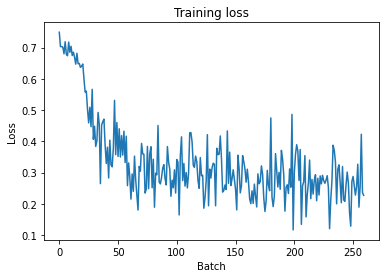

100%|██████████| 260/260 [05:54<00:00,  1.36s/it]



Loss на обучающей выборке: 0.33619

Процент правильных предсказаний на валидационной выборке: 89.18%


In [14]:
from IPython.display import clear_output

# Будем сохранять loss во время обучения
# и рисовать график в режиме реального времени
train_loss_set = []
train_loss = 0


# Обучение
# Переводим модель в training mode
model.train()

stop = False
for step, batch in enumerate(tqdm(train_dataloader)):
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # если не сделать .zero_grad(), градиенты будут накапливаться
    optimizer.zero_grad()
    
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = loss[0]
    train_loss_set.append(loss.item())  
    
    # Backward pass
    loss.backward()
    
    # Обновляем параметры и делаем шаг используя посчитанные градиенты
    optimizer.step()

    # Обновляем loss
    train_loss += loss.item()
    
    # Рисуем график
    clear_output(True)
    plt.plot(train_loss_set)
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.show()

print("\nLoss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))


# Валидация
# Переводим модель в evaluation mode
model.eval()

valid_preds, valid_labels = [], []
for batch in validation_dataloader:   
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для валидационных данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = label_ids
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

print("\nПроцент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

## Тестируем

In [15]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sentences]
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

input_ids = pad_sequences(
    input_ids,
    maxlen=100,
    dtype="long",
    truncating="post",
    padding="post"
)

attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(test_gt)

prediction_data = TensorDataset(
    prediction_inputs,
    prediction_masks,
    prediction_labels
)

prediction_dataloader = DataLoader(
    prediction_data, 
    sampler=SequentialSampler(prediction_data),
    batch_size=BATCH_SIZE
)

In [16]:
model.eval()
predicts, test_labels, text = [], [], []

for batch in tqdm(prediction_dataloader):
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для тестовых данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    batch_labels = b_labels.cpu().numpy()

    # Сохраняем предсказанные классы и ground truth
    batch_preds = np.argmax(logits, axis=1)

    predicts.extend(batch_preds)
    test_labels.extend(batch_labels)
    text.extend(b_input_ids)

acc_score = accuracy_score(test_labels, predicts)
print('Процент правильных предсказаний на отложенной выборке составил: {0:.2f}%'.format(acc_score*100))

100%|██████████| 124/124 [00:52<00:00,  2.35it/s]

Процент правильных предсказаний на отложенной выборке составил: 88.58%


In [17]:
samples = pd.DataFrame({'data': test_sentences, 'test_labels': test_labels, 'predicts': predicts})
samples.head()

,data,test_labels,predicts
0,[CLS] Nacho Vigalondo is very famous in Spain....,0,0
1,[CLS] Julia Stiles is a talented young actress...,0,0
2,[CLS] This is a well made informative film in ...,0,1
3,"[CLS] This ""space snippet"" was kind of dumb. I...",0,0
4,[CLS] Sjöströms masterpiece and a movie that c...,1,1


In [47]:
error_check = samples.test_labels != samples.predicts
errors = samples[error_check]

print('Тексты с ошибками:  ')
for text in errors.sample(5).data:
  text = text.replace('[CLS]', '').replace('[SEP]', '')
  print(text)

Тексты с ошибками:  
 Well, if you are looking for a great mind control movie, this is it. No movie has had so many gorgeous women under mind control, and naked. Marie Forsa, as the busty Helga, is under just about everytime she falls asleep and a few times when she isn't. One wishes they made more movies like this one 
 I don't understand where these bad comments are coming from. The movie had you on the edge of your seat and made you somewhat afraid to go to your car at the end of the night.<br /><br />The part that gets you is that this could all happen. Not to the extent perceived in the movie, but the whole idea is reality. This movie took that reality and twisted it into a Dee Snider nightmare.<br /><br />Three thumbs up (the third one is from the dead body in my freezer 
 hey community! my question is about the song, the pizza man wants Casey to play right after smoking that weed. not his "ragga application song" but the cozy one! thanks <br /><br />this page wants me to write 1

In [48]:
trues = samples[~error_check]

print('Тексты без ошибок:  ')
for text in trues.sample(5).data:
  print(text.replace('[CLS]', '').replace('[SEP]', ''))

Тексты без ошибок:  
 This movie is really nerve racking Cliffhangin movie!Stallone was good as always!Michael Rooker put on a surprising performance and John Lithgow play a excellent villain!The music is fantastic especially the theme!The movie is action packed and never dull!If you are a Stallone fan then watch Cliffhanger,you won't be disappointed 
 The only reason I know this film exists is because I wanted to see what Nancy McKeon had been up to since The Facts of Life ended. When I searched her name, up came this relatively new TV movie. After much investigation I managed to locate a copy & was thoroughly disappointed with what I viewed. D Grade acting, poor script, terrible FX - it was like watching a toned down, more stupefied version of Day After Tomorrow that went for 3 hours. Despite the long running time the characters remain fairly under-developed, we do not care about them in the slightest & in most cases are longing for their demise. Combine that with terrible lighting &